# Visualization of Cloud-Optimized Earth Observation Data using Lonboard


This tutorial illustrates processing and visualizing EO data - Cloud-Optimized GeoTIFFs (COGs) and Cloud-Optimized Point Clouds (COPCs) using Lonboard. Lonboard is capable of visualizing big raster and vector datasets including widely used image formats such as COGs and LiDAR data files such as COPCs, LAS file formats.

In this tutorial, Airborne LiDAR Scanning (ALS, from YellowScan equipped with Q240 LiDAR Sensor) based point clouds for **Gbele Resource Reserve**, **Kakum Conservation Area** and **Bobiri Forest Reserve, Ghana** are used for visualization along with the Digital Terrain Model (DTM) also derived from the ALS. We created COGs for these products and use TiTiler for dynamically serving tiles from the generated COGs for visualization. The point cloud represents normalized canopy cover heights generated from the raw point cloud data.

Additional Resources:

1. [Lonboard](https://developmentseed.org/lonboard/latest/)
2. [TiTiler](https://developmentseed.org/titiler/)
3. [Converting LiDAR LAS Files to Cloud-Optimized Point Clouds (COPCs)](https://guide.cloudnativegeo.org/copc/lidar-las-to-copc.html)
4. [Introduction to Cloud-Optimized GeoTIFFs](https://guide.cloudnativegeo.org/cloud-optimized-geotiffs/intro.html)
5. [PDAL](https://pdal.io/en/2.6.0/about.html#what-is-pdal)

### Importing Packages
We import the required packages for this tutorial.

This notebook is designed to run on the NASA MAAP in a "Pangeo" workspace.
To prepare your workspace, install packages via the terminal and restart the kernel in this notebook with:  
`conda env update -f /projects/shared-buckets/minord/biomass_reference_maps/env/lonboard-env.yml --prune`

### 1. Creating executed notebook
`python -m nbconvert /projects/ADE_biomass_harmonization/NASA_CMS/NASA_CMS_2023/Ghana/ghana_fao_pointclound_viz.ipynb --to ipynb --stdout --execute > /projects/ADE_biomass_harmonization/NASA_CMS/NASA_CMS_2023/Ghana/ghana_fao_pointclound_viz_executed.ipynb`
### 2. Create shared notebook
`pip install nbss-upload`

`nbss-upload /projects/ADE_biomass_harmonization/NASA_CMS/NASA_CMS_2023/Ghana/ghana_fao_pointclound_viz_executed.ipynb`

In [1]:
import geopandas as gpd
from lonboard import viz
import pdal
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from lonboard import Map, BitmapLayer, BitmapTileLayer, PointCloudLayer, PolygonLayer
from lonboard.colormap import apply_continuous_cmap
import httpx
import json
from palettable.colorbrewer.sequential import YlGnBu_7, Greens_3
from palettable.colorbrewer.diverging import Spectral_9
from matplotlib.colors import Normalize
import matplotlib.image as img 
from lonboard import Map, PolygonLayer

(PDAL Error) Can't load library /opt/conda/envs/pangeo/lib/libpdal_plugin_reader_draco.so: Failed to load "/opt/conda/envs/pangeo/lib/libpdal_plugin_reader_draco.so": libdraco.so.8: cannot open shared object file: No such file or directory(PDAL Error) Can't load library /opt/conda/envs/pangeo/lib/libpdal_plugin_writer_draco.so: Failed to load "/opt/conda/envs/pangeo/lib/libpdal_plugin_writer_draco.so": libdraco.so.8: cannot open shared object file: No such file or directory(PDAL Error) Can't load library /opt/conda/envs/pangeo/lib/libpdal_plugin_reader_draco.so: Failed to load "/opt/conda/envs/pangeo/lib/libpdal_plugin_reader_draco.so": libdraco.so.8: cannot open shared object file: No such file or directory(PDAL Error) Can't load library /opt/conda/envs/pangeo/lib/libpdal_plugin_writer_draco.so: Failed to load "/opt/conda/envs/pangeo/lib/libpdal_plugin_writer_draco.so": libdraco.so.8: cannot open shared object file: No such file or directory

#### Next, we define the paths to the ALS LiDAR files in COPC (cloud optimized point cloud) format to be visualized. 

In [2]:
#Bobiri Forest Reserve, plot BOB-05
BOB_05_out_file = "/projects/shared-buckets/minord/data/ghana_fao/ALS_ground/outputs/norm/norm_chunk_687000_740200.copc.laz"
#Gbele Resource Reserve, plot GRR-01
GRR_01_out_file = "/projects/shared-buckets/minord/data/ghana_fao/ALS_ground/outputs/norm/norm_chunk_600900_1151700.copc.laz"
#Kakum Conservation Area, plot KCA-02
KCA_02_out_file = "/projects/shared-buckets/minord/data/ghana_fao/ALS_ground/outputs/norm/norm_chunk_688500_615500.copc.laz"

### Reading the COPC file  
We read the COPC file using the PDAL python package. Also, we sample the points a user-defined density (e.g. sample every 50th point), thus reducing the number of points for visualization to save memory. PDAL processes point cloud data by executing pipelines comprising of various operations (separated by | below). For more details, the readers are recommended 
to follow [Converting LiDAR LAS Files to Cloud-Optimized Point Clouds (COPCs)](https://guide.cloudnativegeo.org/copc/lidar-las-to-copc.html).

In [3]:
BOB_05_pipeline = (pdal.Reader.copc(filename=BOB_05_out_file) | pdal.Filter.decimation(step=20) | pdal.Filter.stats())
BOB_05_pipeline.execute()

GRR_01_pipeline = (pdal.Reader.copc(filename=GRR_01_out_file) | pdal.Filter.decimation(step=20) | pdal.Filter.stats())
GRR_01_pipeline.execute()

KCA_02_pipeline = (pdal.Reader.copc(filename=KCA_02_out_file) | pdal.Filter.decimation(step=20) | pdal.Filter.stats())
KCA_02_pipeline.execute()

344814

### Getting the Data Values
The data values from an executed pipeline are retrieved by calling the arrays method.

In [4]:
# Getting array values
BOB_05_arr_values = BOB_05_pipeline.arrays
GRR_01_arr_values = GRR_01_pipeline.arrays
KCA_02_arr_values = KCA_02_pipeline.arrays

### Creating Geo-dataframe
Now, we will create a data frame followed by a Geo-dataframe based on the data values. Lonboard requires the vector data as Geo-dataframe for visualization.

In [5]:
BOB_05_df = pd.DataFrame(BOB_05_arr_values[0])
GRR_01_df = pd.DataFrame(GRR_01_arr_values[0])
KCA_02_df = pd.DataFrame(KCA_02_arr_values[0])

In [6]:
BOB_05_gdf = gpd.GeoDataFrame(BOB_05_df, geometry=gpd.points_from_xy(BOB_05_df.X, BOB_05_df.Y, z=BOB_05_df.Z), crs="32630") #UTM Zone 30N
GRR_01_gdf = gpd.GeoDataFrame(GRR_01_df, geometry=gpd.points_from_xy(GRR_01_df.X, GRR_01_df.Y, z=GRR_01_df.Z), crs="32630") #UTM Zone 30N
KCA_02_gdf = gpd.GeoDataFrame(KCA_02_df, geometry=gpd.points_from_xy(KCA_02_df.X, KCA_02_df.Y, z=KCA_02_df.Z), crs="32630") #UTM Zone 30N


Also, Lonboard requires the Geo-dataframe to have its Spatial Reference System (SRS) as World Geodetic System 1984 (WGS 84). So, we re-project the geo-dataframe to EPSG 4326, which is the unique reference code for WGS 84.

In [7]:
BOB_05_gdf_proj = BOB_05_gdf.to_crs(4326)
BOB_05_gdf_proj.head()

GRR_01_gdf_proj = GRR_01_gdf.to_crs(4326)
GRR_01_gdf_proj.head()

KCA_02_gdf_proj = KCA_02_gdf.to_crs(4326)
KCA_02_gdf_proj.head()

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,ScanAngleRank,UserData,PointSourceId,GpsTime,ScanChannel,ClassFlags,Red,Green,Blue,Zref,geometry
0,688994.31,615760.59,3.50,0,2,2,0,0,1,-20.568001,1,1003,59509.372066,0,0,47802,63222,54741,157.093,POINT Z (-1.29381 5.56833 3.50000)
1,688986.48,615765.25,0.71,8670,1,1,0,0,1,-17.100000,1,1003,59509.767490,0,0,43690,60652,54998,154.340,POINT Z (-1.29388 5.56837 0.71000)
2,688985.08,615758.91,3.88,10455,1,1,0,0,1,-19.620001,1,1003,59509.828187,0,0,47031,62708,54998,156.469,POINT Z (-1.29389 5.56832 3.88000)
3,688987.75,615765.61,0.61,8925,1,1,0,0,1,-16.266001,1,1003,59509.856320,0,0,42148,59624,54741,153.606,POINT Z (-1.29387 5.56838 0.61000)
4,688987.74,615759.08,0.01,8925,1,1,0,0,2,-18.695999,1,1003,59509.879237,0,0,41377,59110,54484,153.164,POINT Z (-1.29387 5.56832 0.01000)



In order to save memory, we delete the unrequired data frames. Also, we drop the columns which are not relevant for the visulization.

In [8]:
# Deleting not required dataframes
del(BOB_05_df)
del(BOB_05_gdf)
del(GRR_01_df)
del(GRR_01_gdf)
del(KCA_02_df)
del(KCA_02_gdf)

In [9]:
#Dropping not required columns
BOB_05_gdf_proj = BOB_05_gdf_proj.drop(['ReturnNumber', 'NumberOfReturns', 'ScanDirectionFlag', 'EdgeOfFlightLine', 'ScanAngleRank', 'UserData', 'PointSourceId', 'GpsTime', 'Intensity', 'Classification', 'ScanChannel', 'ClassFlags', 'Zref'], axis=1)
GRR_01_gdf_proj = GRR_01_gdf_proj.drop(['ReturnNumber', 'NumberOfReturns', 'ScanDirectionFlag', 'EdgeOfFlightLine', 'ScanAngleRank', 'UserData', 'PointSourceId', 'GpsTime', 'Intensity', 'Classification', 'ScanChannel', 'ClassFlags', 'Zref'], axis=1)
KCA_02_gdf_proj = KCA_02_gdf_proj.drop(['ReturnNumber', 'NumberOfReturns', 'ScanDirectionFlag', 'EdgeOfFlightLine', 'ScanAngleRank', 'UserData', 'PointSourceId', 'GpsTime', 'Intensity', 'Classification', 'ScanChannel', 'ClassFlags', 'Zref'], axis=1)


### Define a Point Cloud Layer
We define a Point Cloud Layer based on the geo-dataframe.

In [10]:
BOB_05_point_layer = PointCloudLayer.from_geopandas(BOB_05_gdf_proj, point_size=2)
GRR_01_point_layer = PointCloudLayer.from_geopandas(GRR_01_gdf_proj, point_size=2)
KCA_02_point_layer = PointCloudLayer.from_geopandas(KCA_02_gdf_proj, point_size=2)

### Styling Point Cloud Layer
Here, we normalize the elevation values and create a color map for visualizing the point cloud layer.

In [11]:
maxZ = pd.concat([BOB_05_gdf_proj["Z"],GRR_01_gdf_proj["Z"],KCA_02_gdf_proj["Z"]]).max()
if (maxZ > 60): 
    maxZ = 60

In [12]:
BOB_05_normalizer = Normalize(1, maxZ, clip=True)
BOB_05_normalized_heights = BOB_05_normalizer(BOB_05_gdf_proj["Z"])

GRR_01_normalizer = Normalize(1, maxZ, clip=True)
GRR_01_normalized_heights = GRR_01_normalizer(GRR_01_gdf_proj["Z"])

KCA_02_normalizer = Normalize(1, maxZ, clip=True)
KCA_02_normalized_heights = KCA_02_normalizer(KCA_02_gdf_proj["Z"])

In [13]:
BOB_05_point_layer.get_color = apply_continuous_cmap(BOB_05_normalized_heights, Greens_3, alpha=0.6)
GRR_01_point_layer.get_color = apply_continuous_cmap(GRR_01_normalized_heights, Greens_3, alpha=0.6)
KCA_02_point_layer.get_color = apply_continuous_cmap(KCA_02_normalized_heights, Greens_3, alpha=0.6)

### Reading Digital Terrain Model (DTM) Product Layer
For visualizing COGs, we use BitmapTileLayer which renders tiles dynamically generated by TiTiler

In [14]:
titiler_endpoint = "https://titiler.maap-project.org"

In [15]:
#DTM product stored locally in MAAP workspace
BOB_05_dtm_product_url = "s3://maap-ops-workspace/shared/minord/data/ghana_fao/ALS_ground/outputs/dtm/BOB_05_dtm.tif"
GRR_01_dtm_product_url = "s3://maap-ops-workspace/shared/minord/data/ghana_fao/ALS_ground/outputs/dtm/GRR_01_dtm.tif"
KCA_02_dtm_product_url = "s3://maap-ops-workspace/shared/minord/data/ghana_fao/ALS_ground/outputs/dtm/KCA_02_dtm.tif"

In [16]:
BOB_05_dtm_product_tile_url = "https://titiler.maap-project.org/cog/tiles/{z}/{x}/{y}?url=s3://maap-ops-workspace/shared/minord/data/ghana_fao/ALS_ground/outputs/dtm/BOB_05_dtm.tif"
GRR_01_dtm_product_tile_url = "https://titiler.maap-project.org/cog/tiles/{z}/{x}/{y}?url=s3://maap-ops-workspace/shared/minord/data/ghana_fao/ALS_ground/outputs/dtm/GRR_01_dtm.tif"
KCA_02_dtm_product_tile_url = "https://titiler.maap-project.org/cog/tiles/{z}/{x}/{y}?url=s3://maap-ops-workspace/shared/minord/data/ghana_fao/ALS_ground/outputs/dtm/KCA_02_dtm.tif"

In [17]:
## This cell pulls in the DTMs with Titiler

r_BOB_05_dtm = httpx.get(
    f"{titiler_endpoint}/cog/info",
    params = {
        "url": BOB_05_dtm_product_url,
    }
).json()

bounds_BOB_05_dtm = r_BOB_05_dtm["bounds"]
print(bounds_BOB_05_dtm)

r_GRR_01_dtm = httpx.get(
    f"{titiler_endpoint}/cog/info",
    params = {
        "url": GRR_01_dtm_product_url,
    }
).json()

bounds_GRR_01_dtm = r_GRR_01_dtm["bounds"]
print(bounds_GRR_01_dtm)

r_KCA_02_dtm = httpx.get(
    f"{titiler_endpoint}/cog/info",
    params = {
        "url": KCA_02_dtm_product_url,
    }
).json()

bounds_KCA_02_dtm = r_KCA_02_dtm["bounds"]
print(bounds_KCA_02_dtm)

[-1.3077613380094217, 6.69201275905951, -1.3068079470049123, 6.693110123809261]
[-2.078965978320196, 10.415198357040694, -2.076945766280968, 10.417216263555618]
[-1.295808746995082, 5.566496119804284, -1.2937949033091083, 5.568504828176253]


In [18]:
### This cell makes the image that gets displayed on lonboard

BOB_05_dtm_product_layer = BitmapTileLayer(
    data=BOB_05_dtm_product_tile_url,
    tile_size=148,
    max_requests=-1,
    min_zoom=0,
    max_zoom=20,
    extent=bounds_BOB_05_dtm
)

GRR_01_dtm_product_layer = BitmapTileLayer(
    data=GRR_01_dtm_product_tile_url,
    tile_size=148,
    max_requests=-1,
    min_zoom=0,
    max_zoom=20,
    extent=bounds_GRR_01_dtm
)

KCA_02_dtm_product_layer = BitmapTileLayer(
    data=KCA_02_dtm_product_tile_url,
    tile_size=148,
    max_requests=-1,
    min_zoom=0,
    max_zoom=20,
    extent=bounds_KCA_02_dtm
)

In [19]:
#Plot outlines stored locally in MAAP workspace
BOB_05_plot_url = "s3://maap-ops-workspace/shared/minord/data/ghana_fao/plot_outlines/sp.geom_bob_05.png"
GRR_01_plot_url = "s3://maap-ops-workspace/shared/minord/data/ghana_fao/plot_outlines/sp.geom_grr_01.png"
KCA_02_plot_url = "s3://maap-ops-workspace/shared/minord/data/ghana_fao/plot_outlines/sp.geom_kca_02.png"

BOB_05_plot_layer = BitmapLayer(
    image=BOB_05_plot_url,
    bounds=[-1.307763,  6.692113, -1.306813,  6.693062],

    visible=True
)

### Figure of plot locations shown in point-cloud visualization below

In [20]:
plot_locations_url = "/projects/shared-buckets/minord/data/ghana_fao/ghana_pointcloud_plot_locations.png"
im = img.imread(plot_locations_url)

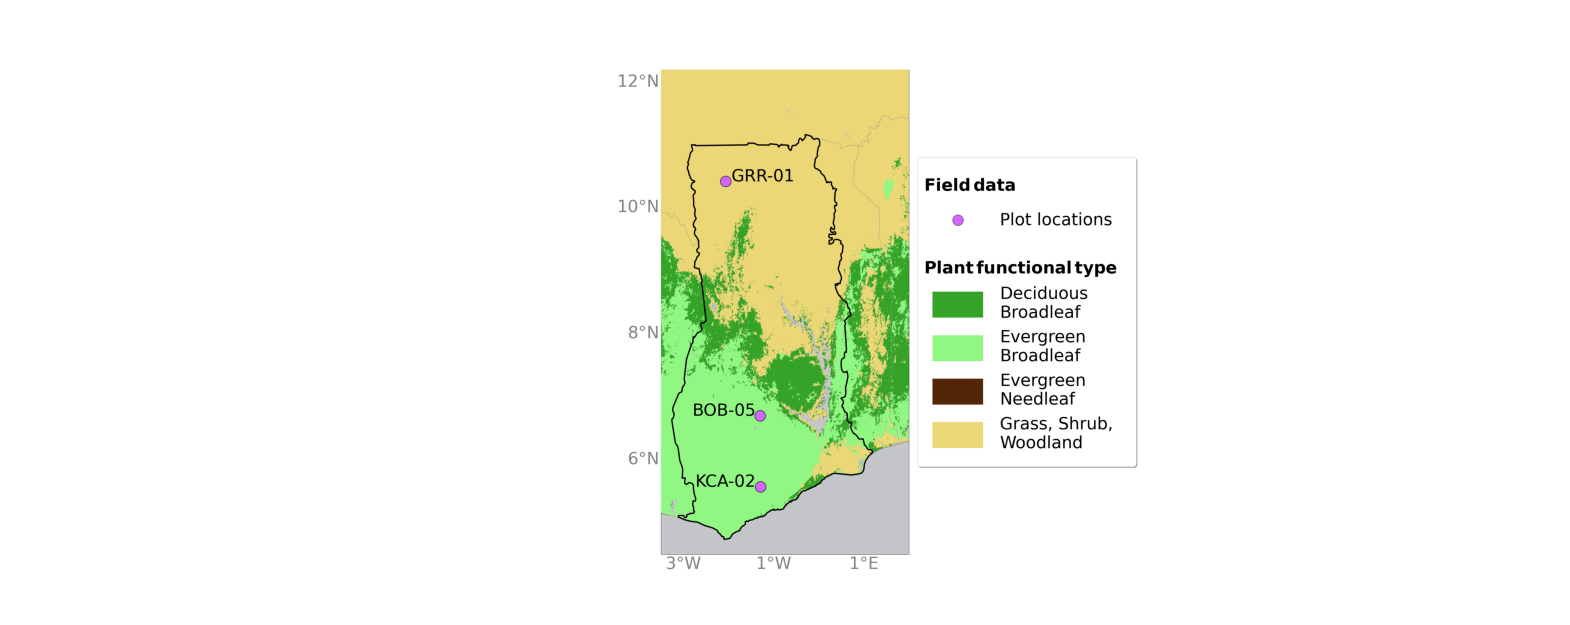

In [21]:
plt.figure(figsize = (20,20))
imgplot = plt.imshow(im)
plt.axis('off')
plt.show()

### Creating Map Visualization for Point cloud and DTM Layers
Here, we visualize the DTM layer, field plot outlines, and point cloud layer in a single Map widget.
The readers are recommended to use **Ctrl+Click+Drag** to change the viewing angle.

In [22]:
Voyager = 'https://basemaps.cartocdn.com/gl/voyager-gl-style/style.json'

In [23]:
#Read in field plot outlines
BOB_05_plot_url = "s3://maap-ops-workspace/shared/minord/data/ghana_fao/plot_outlines/sp_geom_bob_05.geojson"
GRR_01_plot_url = "s3://maap-ops-workspace/shared/minord/data/ghana_fao/plot_outlines/sp_geom_grr_01.geojson"
KCA_02_plot_url = "s3://maap-ops-workspace/shared/minord/data/ghana_fao/plot_outlines/sp_geom_kca_02.geojson"

BOB_05_gdf = gpd.read_file(BOB_05_plot_url)
GRR_01_gdf = gpd.read_file(GRR_01_plot_url)
KCA_02_gdf = gpd.read_file(KCA_02_plot_url)

In [24]:
BOB_05_plot_layer = PolygonLayer.from_geopandas(
    BOB_05_gdf,
    filled=False
)

GRR_01_plot_layer = PolygonLayer.from_geopandas(
    GRR_01_gdf,
    filled=False
)

KCA_02_plot_layer = PolygonLayer.from_geopandas(
    KCA_02_gdf,
    filled=False
)

In [33]:
layer = BitmapTileLayer(
    data="https://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    tile_size=256,
    max_requests=-1,
    min_zoom=0,
    max_zoom=19,
)
m = Map(layer)

# Gbele Resource Reserve, plot GRR-01

In [36]:
GRR_01_m = Map([layer,GRR_01_dtm_product_layer, GRR_01_plot_layer, GRR_01_point_layer], basemap_style = Voyager)
GRR_01_m

Map(basemap_style='https://basemaps.cartocdn.com/gl/voyager-gl-style/style.json', layers=[BitmapTileLayer(data…

# Bobiri Forest Reserve, plot BOB-05

In [34]:
BOB_05_m = Map([layer,BOB_05_dtm_product_layer, BOB_05_plot_layer, BOB_05_point_layer], basemap_style = Voyager)
BOB_05_m

Map(basemap_style='https://basemaps.cartocdn.com/gl/voyager-gl-style/style.json', layers=[BitmapTileLayer(data…

# Kakum Conservation Area, plot KCA-02

In [35]:
KCA_02_m = Map([layer,KCA_02_dtm_product_layer, KCA_02_plot_layer, KCA_02_point_layer], basemap_style = Voyager)
KCA_02_m

Map(basemap_style='https://basemaps.cartocdn.com/gl/voyager-gl-style/style.json', layers=[BitmapTileLayer(data…